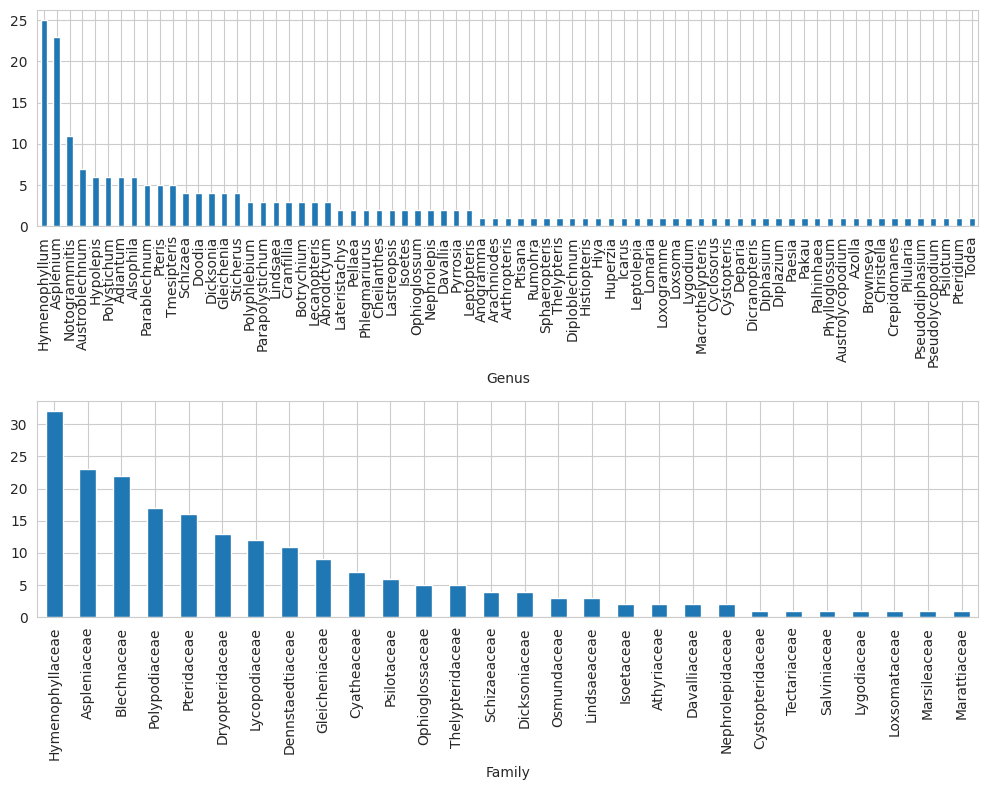

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
from tqdm import tqdm

from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
data_path = Path('Ferns')

def load_raster(f, grid_step=.1):
    raster = xr.open_dataarray(f)
    current_step = (raster.x[1] - raster.x[0]).values # degrees
    downsample = round(grid_step / current_step)
    raster = raster.coarsen(x=downsample, y=downsample, boundary="trim").sum()
    return raster

species_list = pd.read_excel(data_path / 'Species list.xlsx')
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
species_list.Genus.value_counts().plot(kind='bar', ax=ax[0])
species_list.Family.value_counts().plot(kind='bar', ax=ax[1])
plt.tight_layout()
plt.show()

# Data inspection

## Traits

NameError: name 'dataset' is not defined

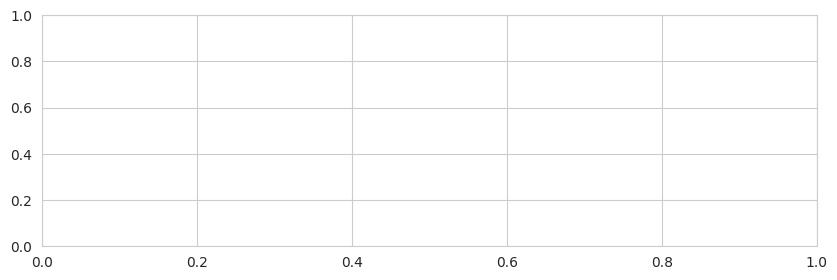

In [2]:
traits = pd.read_excel(data_path / 'Traits.xlsx')
traits_mean = pd.read_excel(data_path / 'Traits.xlsx', sheet_name='Mean').set_index('Species')
traits_var = pd.read_excel(data_path / 'Traits.xlsx', sheet_name='Var').drop(columns=['Family', 'Habitat', 'Hybridisation']).set_index('Species')
traits_std = traits_var.apply(np.sqrt).rename(columns=lambda x: x.replace('Var', 'Std'))

traits_all = traits_mean.join(traits_std)
traits_all = traits_all.drop(index='Hymenophyllum_falklandicum') # missing information
# traits_all.columns = traits_all.columns.map('_'.join)

fig, ax = plt.subplots(figsize=(10, 3))
(dataset.dataset.dataset.dataset.traits_all.isna().sum().sort_values() / len(traits_mean)).plot(kind='bar', ax=ax, title='Missing values')
plt.axhline(y=.6, color='r', linestyle='--', lw=1)
plt.show()

In [3]:
list(zip(sorted(traits_mean.columns[traits_mean.dtypes.eq('float64')&(traits_mean.columns!='Hybridisation')&~traits_mean.columns.str.startswith('Rhizome')]), sorted(traits_var.columns[traits_var.dtypes == 'float64'])))

[('Altmean', 'AltRange'),
 ('Ferstipemean', 'FerstipeVar'),
 ('Fertile frond mean', 'FertfrondVar'),
 ('Fertlaminamean', 'FertlaminaVar'),
 ('Fertlamlengthmean', 'FertlaminalengthVar'),
 ('Fertlamwidthmean', 'FertlaminawidthVar'),
 ('Frondmean', 'FrondVar'),
 ('Laminalengthmean', 'LaminaVar'),
 ('Laminareamean', 'LaminalengthVar'),
 ('Laminawidthmean', 'LaminawidthVar'),
 ('Sporemean', 'SporeVar'),
 ('Stipemean', 'StipeVar')]

In [4]:
for cl_feat in ['Habitat', 'Family']:
    for cl in traits_all[cl_feat].unique():
        if traits_all[cl_feat].eq(cl).sum() < len(traits_all) * 0.05:
            traits_all[cl_feat] = traits_all[cl_feat].replace({cl: 'Other'})
traits_all = pd.get_dummies(traits_all, drop_first=True)

class_idx = {
    'Habitat': [traits_all.columns.get_loc(c) for c in traits_all.columns if c.startswith('Habitat')],
    'Family': [traits_all.columns.get_loc(c) for c in traits_all.columns if c.startswith('Family')],
}
# df = df.drop(columns=[c for c in df.columns if c.startswith('Habitat') or c.startswith('Family')])

## Species Graph

In [233]:
from Bio import Phylo

# Load the tree
tree_file = data_path/"grafted_tree.nwk"
tree = Phylo.read(tree_file, "newick")

# Print a text-based visualization
Phylo.draw_ascii(tree)


                      _________ Anogramma_leptophylla
                     |
                     |   ______ Pteris_epaleata
                _____|  |
               |     |  |      , Pteris_macilenta
               |     |  |    __|
               |     |__|___|  | Pteris_saxatilis
               |        |   |
               |        |   |__ Pteris_tremula
               |        |
               |        |______ Pteris_carsei
            ___|
           |   |              , Cheilanthes_distans
           |   |          ____|
           |   |         |    | Cheilanthes_sieberi
           |   | ________|
           |   ||        |     , Pellaea_calidirupia
           |   ||        |_____|
           |   ||              | Pellaea_rotundifolia
           |   ||
           |   ||             , Adiantum_aethiopicum
           |    |             |
           |    |             | Adiantum_hispidulum
           |    |           __|
           |    |          |  |, Adiantum_cunninghamii
     

In [234]:
# tree to networkx
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
for clade in tree.get_nonterminals():  # Internal nodes (non-leaf)
    if clade.name is None:
        clade.name = f"temp_{id(clade)}"
    for child in clade.clades:
        if child.name is None:
            child.name = f"temp_{id(child)}"
        G.add_edge(clade.name, child.name, weight=child.branch_length)

# Visualize graph info
print("Graph nodes:", G.nodes())
print("Graph edges:", G.edges(data=True))

Graph nodes: ['temp_138583587690288', 'temp_138574013438656', 'temp_138574336036544', 'temp_138574013178624', 'Ptisana_salicina', 'temp_138574013183472', 'temp_138574336043744', 'temp_138574013175408', 'temp_138581818241008', 'temp_138574013185584', 'temp_138581818243840', 'temp_138574013619408', 'temp_138581818240624', 'temp_138574013613744', 'temp_138581818231360', 'temp_138574013626560', 'temp_138581818237168', 'temp_138574013624880', 'temp_138574013620944', 'temp_138574013617920', 'temp_138574013624736', 'Anogramma_leptophylla', 'temp_138574013626944', 'Pteris_epaleata', 'temp_138574013616288', 'Pteris_carsei', 'temp_138574013615616', 'Pteris_tremula', 'Pteris_macilenta', 'Pteris_saxatilis', 'temp_138574013614512', 'temp_138574013622720', 'temp_138574013627904', 'temp_138574013620608', 'Cheilanthes_distans', 'Cheilanthes_sieberi', 'Pellaea_calidirupia', 'Pellaea_rotundifolia', 'temp_138574013618064', 'Adiantum_formosum', 'temp_138574013617488', 'temp_138574013623392', 'Adiantum_aet

In [235]:
from node2vec import Node2Vec

# Train Node2Vec model
node2vec = Node2Vec(G, dimensions=16, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Create node embeddings
node_embeddings = {node: model.wv[node] for node in G.nodes()}

Computing transition probabilities: 100%|██████████| 374/374 [00:00<00:00, 47940.76it/s]


Generating walks (CPU: 4): 100%|██████████| 50/50 [00:01<00:00, 45.10it/s]


In [236]:
import itertools

leaf_nodes = [leaf.name for leaf in tree.get_terminals()]

G_species = nx.Graph()


# Compute pairwise phylogenetic distances between all leaves
for species1, species2 in itertools.combinations(leaf_nodes, 2):
    dist = tree.distance(species1, species2)  # Compute phylogenetic distance
    G_species.add_edge(species1, species2, weight=dist)

# Print some info
print("Total nodes (species only):", len(G_species.nodes))
print("Total edges before pruning:", len(G_species.edges))

median = np.median([d["weight"] for u, v, d in G_species.edges(data=True)])
print(f"Median distance: {median}\n")
sym_threshold = median

# Prune the graph by removing edges with weight > sym_threshold
edges_to_remove = [(u, v) for u, v, d in G_species.edges(data=True) if d["weight"] > sym_threshold]
G_species.remove_edges_from(edges_to_remove)
print("Number of connected components:", nx.number_connected_components(G_species))
print("Total edges after pruning:", len(G_species.edges))

Total nodes (species only): 190
Total edges before pruning: 17955
Median distance: 697.767902

Number of connected components: 7
Total edges after pruning: 9057


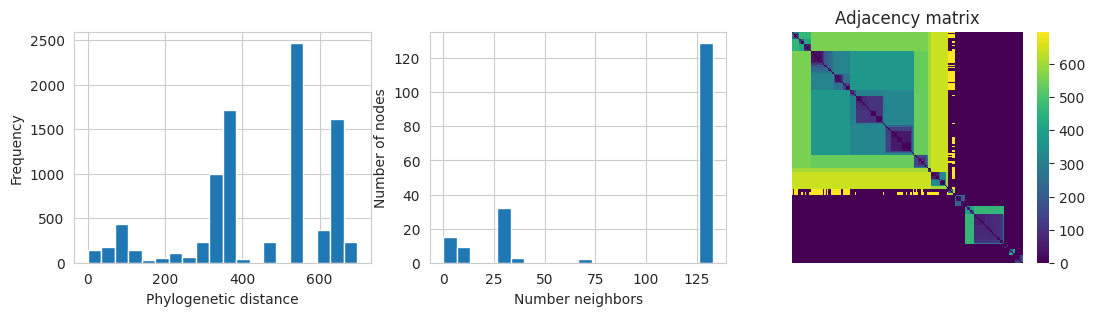

In [237]:
# histogram of the distances
fig, ax = plt.subplots(1, 3, figsize=(13, 3))
ax[0].hist([d['weight'] for _, _, d in G_species.edges(data=True)], bins=20)
ax[0].set_xlabel("Phylogenetic distance")
ax[0].set_ylabel("Frequency")

ax[1].set_xlabel("Number neighbors")
ax[1].set_ylabel("Number of nodes")
ax[1].hist([len(list(G_species.neighbors(n))) for n in G_species.nodes], bins=20)

sns.heatmap(nx.to_numpy_array(G_species), cmap="viridis", xticklabels=False, yticklabels=False, ax=ax[2], square=True)
ax[2].set_title("Adjacency matrix")
plt.show()

In [238]:
import torch
from torch_geometric.utils import from_networkx

# Remove species not present in the traits
G_species.remove_nodes_from(list(set(G_species.nodes).difference(traits_all.index)))

for node in G_species.nodes():
    G_species.nodes[node]["x"] = node_embeddings[node]
species_data = from_networkx(G_species)  # Include node attributes
species_data.node_names = [n for n in G_species.nodes()]  # Map node names to indices

# Add nodes not present in the ph_tree
for node in traits_all.index.difference(species_data.node_names):
    species_data.node_names.append(node)
    species_data.x = torch.cat([species_data.x, torch.zeros(1, species_data.num_features)], dim=0)

species_data.traits_nanmask = torch.tensor(traits_all.loc[species_data.node_names].isna().values, dtype=torch.bool)
species_data.traits = torch.tensor(traits_all.loc[species_data.node_names].fillna(0).astype(np.float32).values, dtype=torch.float32)

# Print PyG graph details
print(species_data)


Data(x=[206, 16], edge_index=[2, 17796], weight=[17796], node_names=[206], traits_nanmask=[206, 38], traits=[206, 38])


/home/smonaco/miniconda3/lib/python3.12/site-packages/torch_geometric/utils/convert.py:278: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  data_dict[key] = torch.as_tensor(value)


## Occurrences - Space graph

In [ ]:
all_occurrences = xr.open_dataarray(data_path/"Distribution layers/_all_species_distributions_with species info.tif")

In [220]:
space_df = all_occurrences.isel(band=0).to_pandas().reset_index().melt(id_vars=['y']).rename(columns={'value': 'occurrence'})
space_df.x = space_df.x.astype(np.float32)
space_df.y = space_df.y.astype(np.float32)
space_df = space_df[space_df.occurrence > 0].drop(columns='occurrence').reset_index(drop=True)

In [116]:
from sklearn.cluster import SpectralClustering
n_clusters = range(2, 50)
silhouette = []
for n in n_clusters:
    clustering = SpectralClustering(n_clusters=n, random_state=0).fit(space_df[['x', 'y']])
    silhouette.append(clustering.inertia_)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(n_clusters, silhouette)
ax[0].set_xlabel('Number of clusters')
ax[1].plot(n_clusters, silhouette)
ax[1].set_xlabel('Number of clusters')
ax[1].set_yscale('log')

/home/smonaco/miniconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


AttributeError: 'SpectralClustering' object has no attribute 'inertia_'

/home/smonaco/miniconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


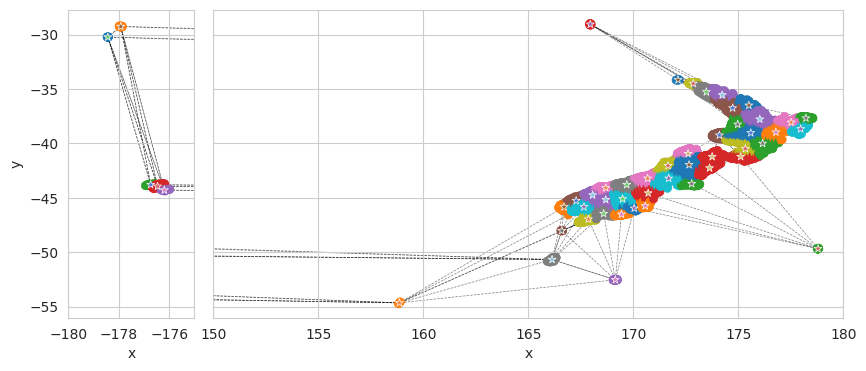

In [221]:
clustering = SpectralClustering(n_clusters=50, random_state=0).fit(space_df[['x', 'y']])
space_df['cluster'] = clustering.labels_

import torch
from torch_geometric.data import Data
from torch_geometric.transforms import KNNGraph

spatial_graph = Data(pos=torch.tensor(space_df.groupby('cluster').agg({'x': 'mean', 'y': 'mean'}).values).float())
spatial_graph = KNNGraph(k=6)(spatial_graph)

# Filter data for x < -175 and x > 150
filtered_df1 = space_df[space_df['x'] < -175]
filtered_df2 = space_df[space_df['x'] > 150]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True, gridspec_kw={'width_ratios': [1, 5], 'wspace': 0.05})

# Scatter plot for x < -175
sns.scatterplot(data=filtered_df1, x='x', y='y', hue='cluster', palette='tab10', legend=False, edgecolor=None, ax=ax1)
ax1.plot(spatial_graph.pos[spatial_graph.edge_index, 0], spatial_graph.pos[spatial_graph.edge_index, 1], '--', c='black', alpha=.5, lw=.5, zorder=0)
sns.scatterplot(data=space_df.groupby('cluster').mean(), x='x', y='y', hue='cluster', ax=ax1, palette='muted', legend=False, zorder=2, marker='*')
ax1.set_xlim(-180, -175)

# Scatter plot for x > 150
sns.scatterplot(data=filtered_df2, x='x', y='y', hue='cluster', palette='tab10', legend=False, edgecolor=None, ax=ax2)
ax2.plot(spatial_graph.pos[spatial_graph.edge_index, 0], spatial_graph.pos[spatial_graph.edge_index, 1], '--', c='black', alpha=.5, lw=.5, zorder=0)
sns.scatterplot(data=space_df.groupby('cluster').mean(), x='x', y='y', hue='cluster', ax=ax2, palette='muted', legend=False, zorder=2, marker='*')
ax2.set_xlim(150, 180)

plt.show()


## Global feats

### Climate data

In [ ]:
clim_rasters = []
mod_name = 'climatic layers'
df_path = (data_path / "complete layers"/f"{mod_name}_space_df.csv")
if df_path.exists():
    clim_df = pd.read_csv(df_path, index_col=0)
else:
    for f in tqdm(list((Path(data_path / "complete layers" / mod_name).rglob('*.tif')))):
        raster = load_raster(f)
        filt_raster = raster.interp(x=space_df.x.values, y=space_df.y.values, method='nearest').isel(band=0)
        filt_raster = filt_raster.to_pandas().reset_index().melt(id_vars=['y']).rename(columns={'value': f.stem})
        clim_rasters.append(space_df.set_index(['x', 'y']).join(filt_raster.set_index(['x', 'y'])).groupby(['cluster']).mean()[f.stem])
    clim_df = pd.concat(clim_rasters, axis=1)
    clim_df.to_csv(df_path)


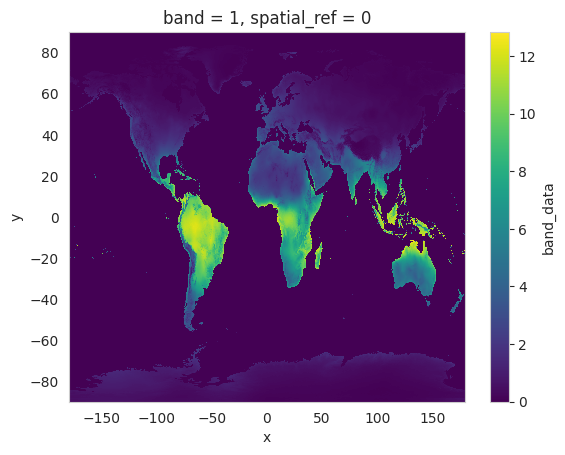

In [57]:
raster.plot()
plt.show()

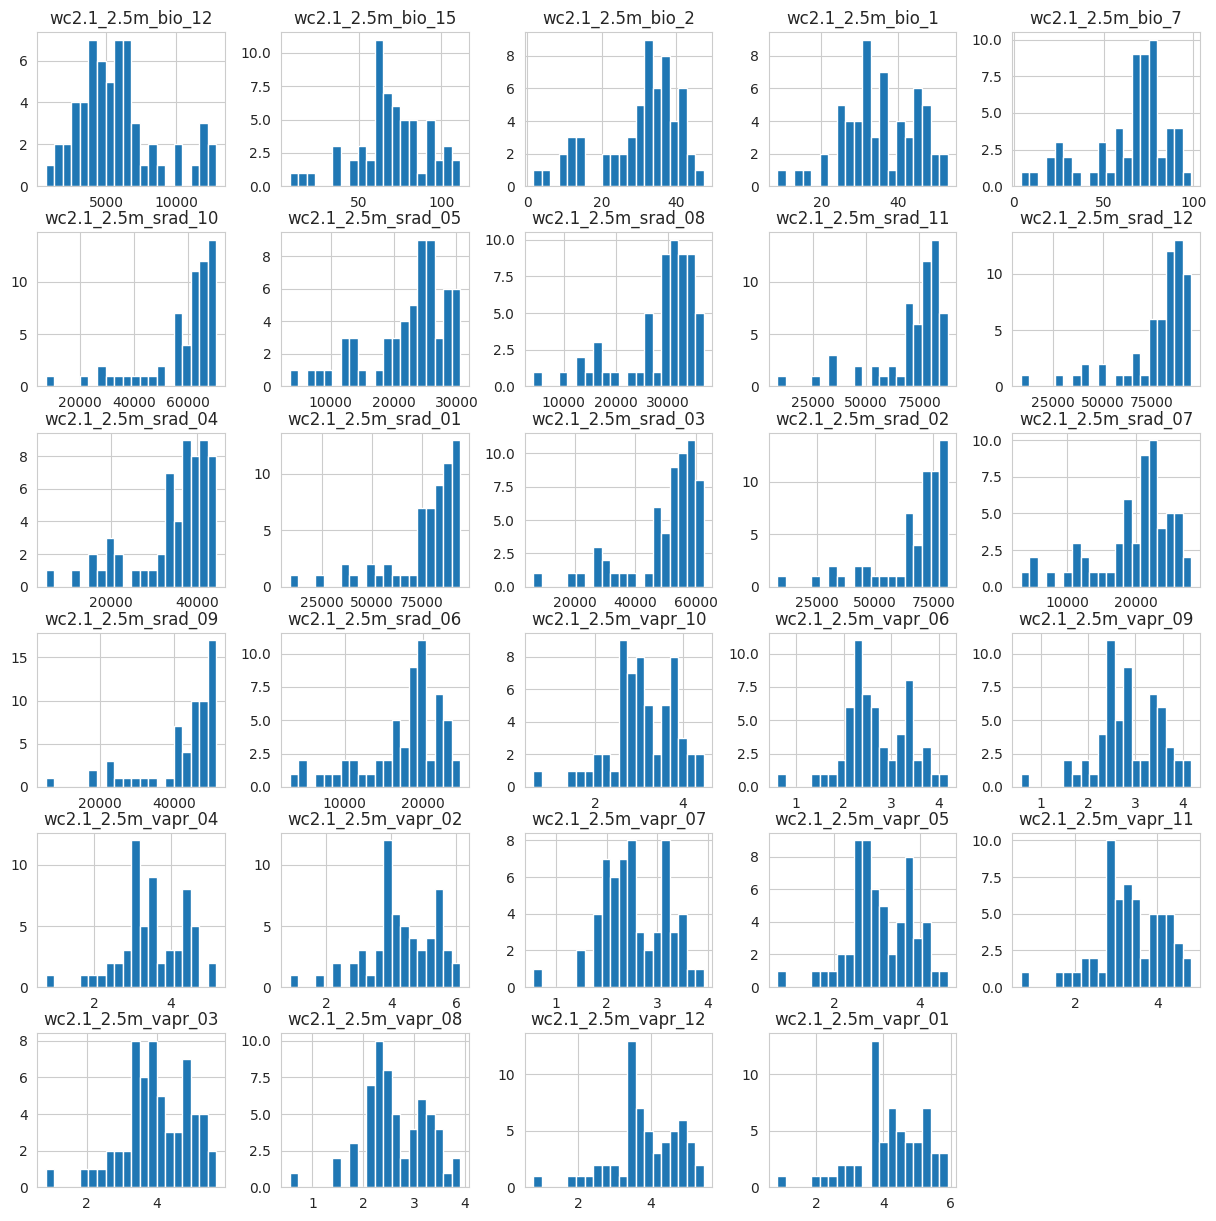

In [55]:
clim_df.hist(bins=20, figsize=(15, 15))
plt.show()

### Population


(-50.0, -34.0)

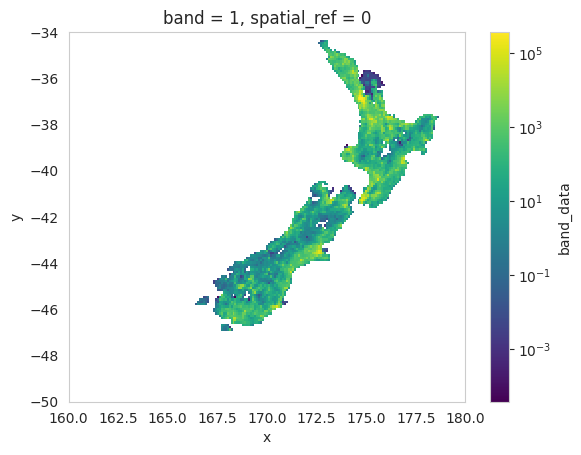

In [58]:
from matplotlib.colors import LogNorm

im_path = Path("Ferns/complete layers/population density and elevation layer/NZ population density layer.tif")
raster_population = load_raster(im_path)

xr.where(raster_population > 0, raster_population, np.nan).plot(norm=LogNorm())
plt.xlim(160, 180)
plt.ylim(-50, -34)

In [76]:
pop_rasters = []
mod_name = 'population density and elevation layer'

df_path = (data_path / "complete layers"/f"{mod_name}_space_df.csv")
if df_path.exists():
    pop_df = pd.read_csv(df_path, index_col=0)
else:
    for f in tqdm(list((Path(data_path / f"complete layers" / mod_name).rglob('*.tif')))):
        raster = load_raster(f)
        filt_raster = raster.interp(x=space_df.x.values, y=space_df.y.values, method='nearest').isel(band=0)
        filt_raster = filt_raster.to_pandas().reset_index().melt(id_vars=['y']).rename(columns={'value': f.stem})
        pop_rasters.append(space_df.set_index(['x', 'y']).join(filt_raster.set_index(['x', 'y'])).groupby(['cluster']).mean()[f.stem])
        if f.stem == 'NZ population density layer':
            pop_rasters[-1] = pop_rasters[-1].apply(np.log1p).fillna(0) # no population there
    pop_df = pd.concat(pop_rasters, axis=1)
    pop_df.to_csv(df_path)


100%|██████████| 2/2 [00:12<00:00,  6.31s/it]


In [ ]:
pop_df.isna().sum()

wc2.1_2.5m_elev                0
NZ population density layer    0
dtype: int64

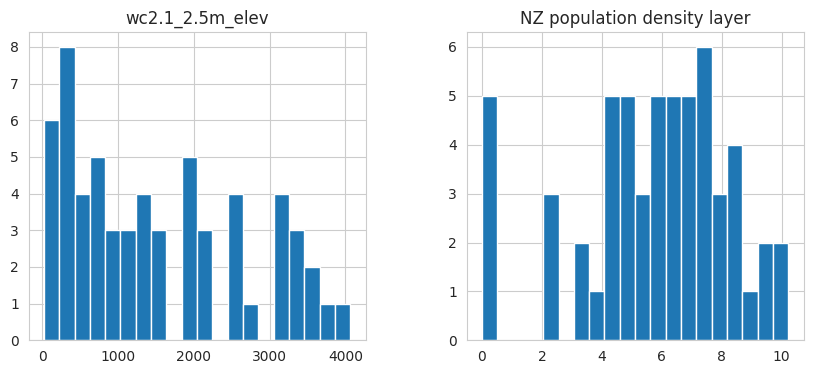

In [64]:
pop_df.hist(bins=20, figsize=(10, 4))
plt.show()

### Soil layers

In [104]:
im_path = Path("Ferns/complete layers/Soil NZ layers/ecoraster.tif")
raster_soil = load_raster(im_path)

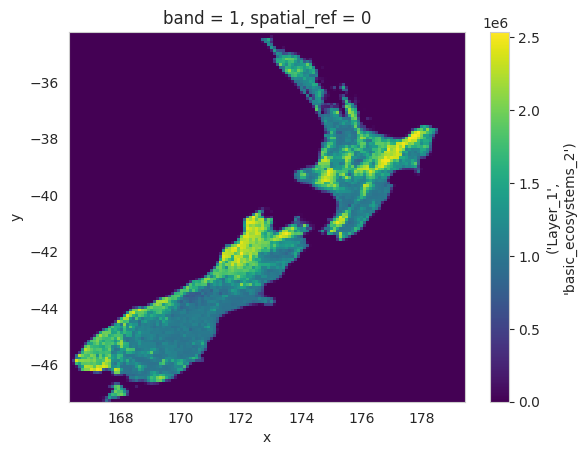

In [110]:
raster_soil.sel(band=1).plot()

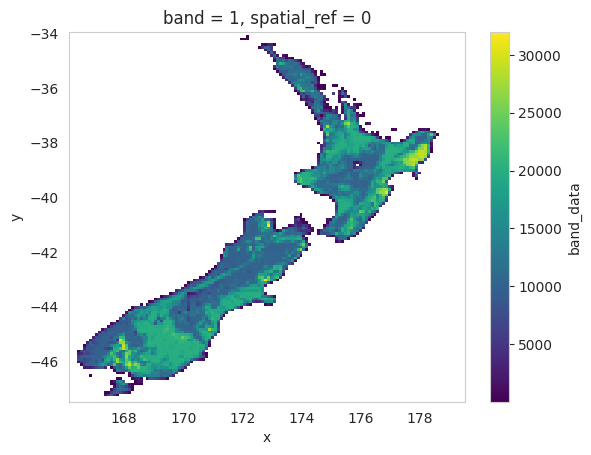

In [ ]:
im_path = Path("Ferns/complete layers/Soil NZ layers/calciumraster.tif")
raster_soil2 = load_raster(im_path)

xr.where(raster_soil2 > 0, raster_soil2, np.nan).plot()

In [68]:
soil_rasters = []
mod_name = 'Soil NZ layers'

df_path = (data_path / "complete layers"/f"{mod_name}_space_df.csv")
if df_path.exists():
    soil_df = pd.read_csv(df_path, index_col=0)
else:
    for f in tqdm(list((Path(data_path / f"complete layers" / mod_name).rglob('*.tif')))):
        raster = load_raster(f)
        filt_raster = raster.interp(x=space_df.x.values, y=space_df.y.values, method='nearest').isel(band=0)
        filt_raster = filt_raster.to_pandas().reset_index().melt(id_vars=['y']).rename(columns={'value': f.stem})
        soil_rasters.append(space_df.set_index(['x', 'y']).join(filt_raster.set_index(['x', 'y'])).groupby(['cluster']).mean()[f.stem])
    soil_df = pd.concat(soil_rasters, axis=1)
    soil_df.to_csv(df_path)


100%|██████████| 9/9 [08:44<00:00, 58.31s/it] 


In [82]:
soil_df.isna().sum()


pHraster                     7
drainageraster               7
phosphorousraster            7
particle_sizeraster          7
ecoraster                    7
hardnessraster               7
soil_ageraster               7
limiation_to_growthraster    7
calciumraster                7
dtype: int64

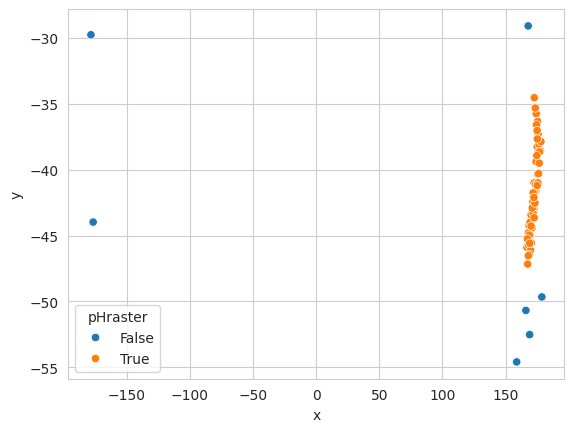

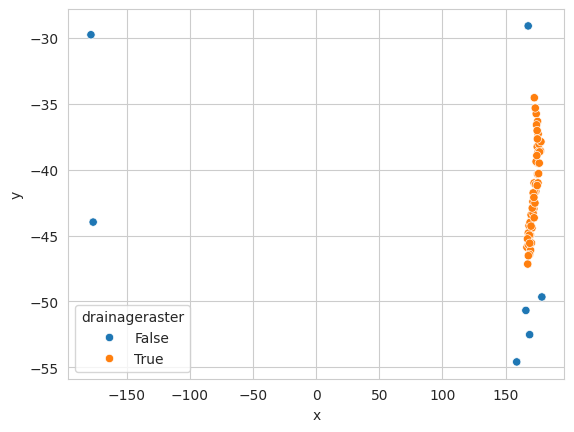

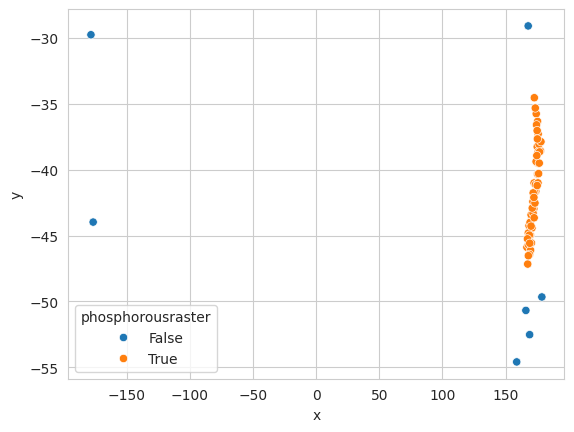

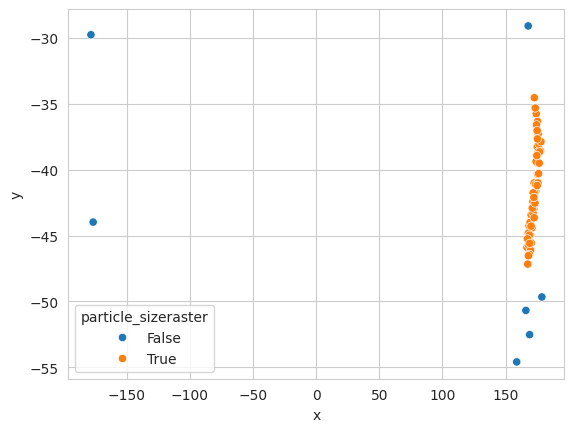

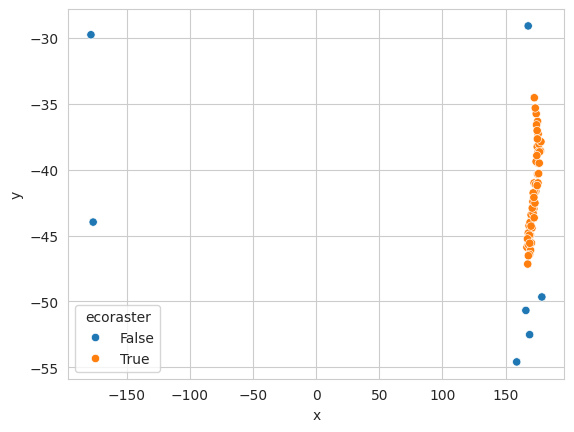

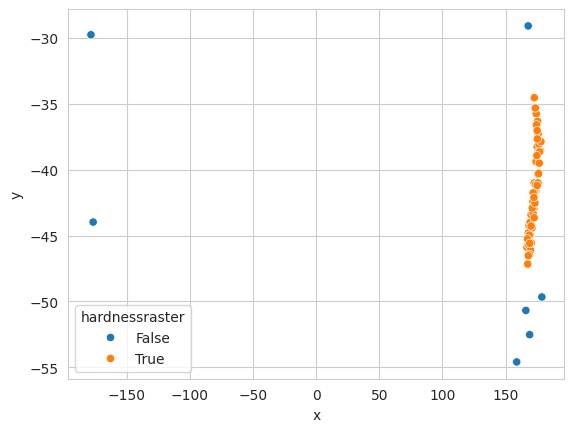

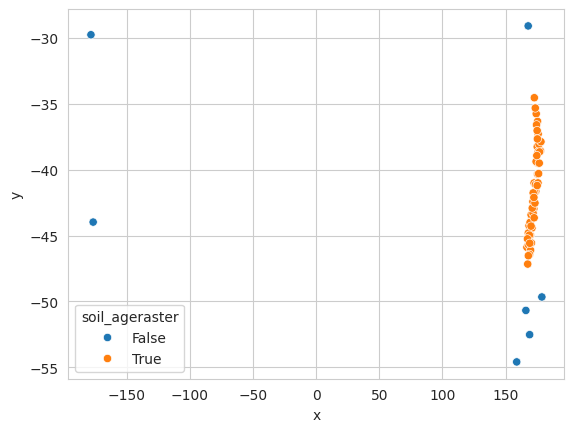

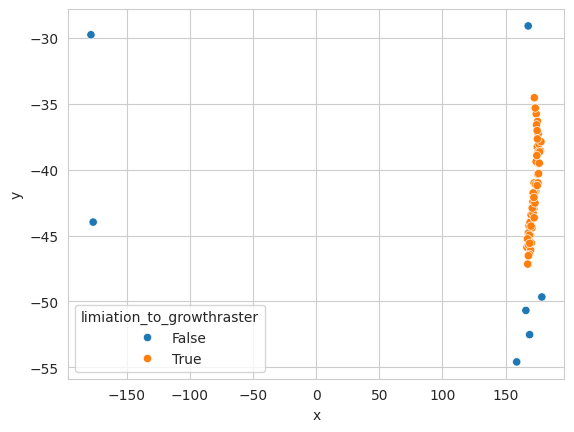

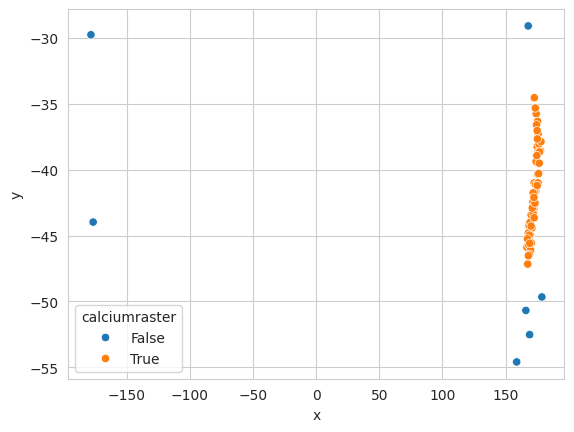

In [83]:
for c in soil_df.columns:
    sns.scatterplot(data=space_df.groupby('cluster').mean(), x='x', y='y', hue=~soil_df[c].isna(), palette='tab10')
    plt.show()

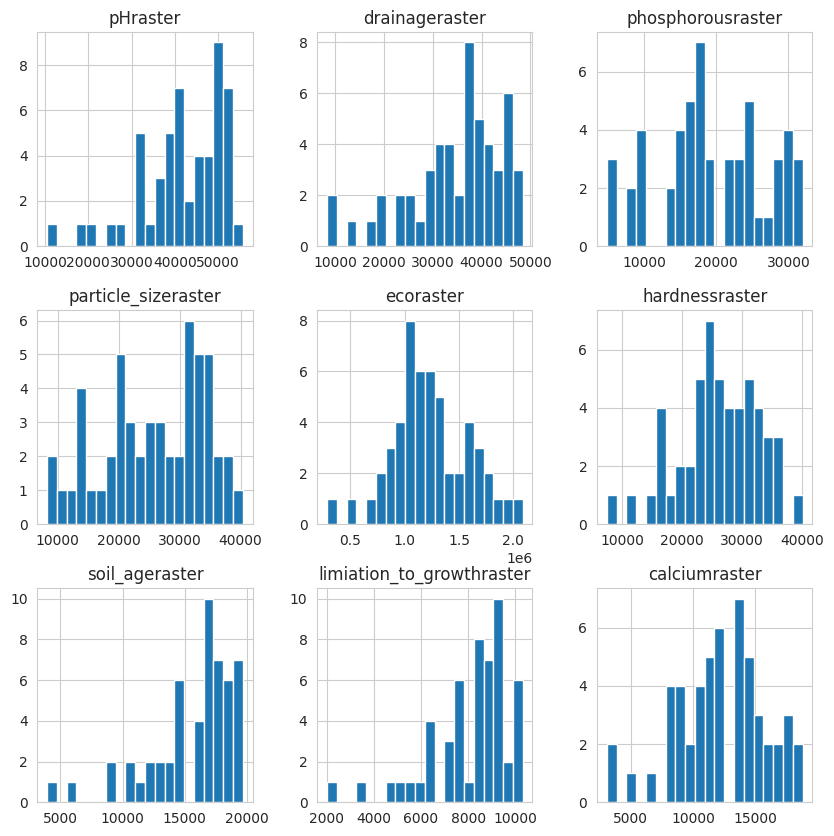

In [73]:
soil_df.hist(bins=20, figsize=(10, 10))
plt.show()

## Occurrences - Single species

In [ ]:
distributions_dir = data_path / 'Distribution layers'

In [231]:
index_space_specie = pd.DataFrame()
for f in tqdm(traits_all.index):
    raster = load_raster(distributions_dir / f"{f}_distribution.tif")
    # raster = raster.sel(x=space_df.x.values, y=space_df.y.values, method='nearest')
    occurence_df = raster.isel(band=0).to_pandas().reset_index().melt(id_vars=['y']).rename(columns={'value': 'occurrence'}).astype(np.float32)
    occurence_df = occurence_df[occurence_df.occurrence > 0]
    # for each x, y; find the closest point in the space_df
    occurence_df[['x', 'y']] = occurence_df[['x', 'y']].apply(lambda x: space_df.iloc[(space_df[['x', 'y']] - x).pow(2).sum(1).idxmin()][['x', 'y']], axis=1)
    occurence_df = occurence_df.set_index(['x', 'y']).join(space_df.set_index(['x', 'y']))
    index_space_specie = pd.concat([occurence_df.groupby('cluster').sum().reset_index().assign(species=f),
                                    index_space_specie,], axis=0, ignore_index=True)

100%|██████████| 206/206 [01:33<00:00,  2.20it/s]


In [240]:
index_space_specie['species_idx'] = index_space_specie.species.apply(lambda x: species_data.node_names.index(x))
bip_edge_index = torch.tensor(index_space_specie[['cluster', 'species_idx']].values.T, dtype=torch.long)
bip_edge_attr = torch.tensor(index_space_specie.occurrence.values, dtype=torch.float32).unsqueeze(1)
Data(bip_edge_index=bip_edge_index, bip_edge_attr=bip_edge_attr)

Data(bip_edge_index=[2, 3915], bip_edge_attr=[3915, 1])

In [177]:
occurence_df['x'] = occurence_df['x'].round(1)
occurence_df['y'] = occurence_df['y'].round(1)

In [223]:
occurence_df

,y,x,occurrence
900,-29.279596,-177.880295,1.0
313972,-35.219597,173.839706,1.0
314061,-35.219597,173.939713,4.0
314062,-35.319595,173.919708,1.0
314514,-36.019596,174.439713,2.0
314515,-36.139595,174.419708,1.0
314604,-36.119595,174.539703,1.0
314605,-36.179596,174.539703,1.0
314693,-36.139595,174.619705,1.0


,cluster,occurrence,species
0,5,1.0,Abrodictyum_caudatum
1,19,8.0,Abrodictyum_caudatum
2,20,4.0,Abrodictyum_caudatum


In [ ]:
occurence_df['cluster'] = space_df.set_index(['x', 'y']).join(occurence_df.set_index(['x', 'y']))
occurence_df

AttributeError: 'SpectralClustering' object has no attribute 'predict'

# Training pipeline

In [1]:
import sys
sys.path.append('..')
from loader import FernDataset, NormalizeFeatures, data_split
from pathlib import Path

norm_transform = NormalizeFeatures()
dataset = FernDataset(Path('Ferns'), transform=norm_transform)
data = dataset[0]
data = data_split(data)
data

/home/smonaco/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Warning Swapped train and test masks ()


Data(x_species=[206, 38], x_species_phylo=[206, 16], x_species_traits_nanmask=[206, 27], x_spatial=[50, 2], species_names=[206], edge_index_species=[2, 17796], edge_index_spatial=[2, 300], edge_attr_species=[17796], edge_attr_spatial=[300, 1], bip_edge_index=[2, 4231], bip_edge_attr=[4231, 1], global_data=[50, 87], num_nodes=206, train_mask=[206], test_mask=[206])

In [ ]:
import numpy as np
import torch
from sklearn.model_selection import GroupShuffleSplit

test_size = .3

G = nx.Graph()
G.add_nodes_from(range(data.num_nodes))
G.add_edges_from(data.edge_index_species.T.numpy())
communities = list(nx.algorithms.community.louvain_communities(G))

# Flatten communities into node indices
node_community = [np.argmax([node in comm for comm in communities]) for node in G.nodes()]


splitter = GroupShuffleSplit(test_size=test_size, random_state=42, n_splits=3)
split = splitter.split(G.nodes(), groups=node_community)
for train_nodes, test_nodes in split:
    print(f'Train nodes: {len(train_nodes)}, Test nodes: {len(test_nodes)}')

# train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
# test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

# train_mask[train_nodes] = True
# test_mask[test_nodes] = True

# if train_mask.sum() < test_mask.sum():
#     train_mask, test_mask = test_mask, train_mask
#     print(f'Warning Swapped train and test masks ()')



Train nodes: 56, Test nodes: 150
Train nodes: 29, Test nodes: 177
Train nodes: 193, Test nodes: 13


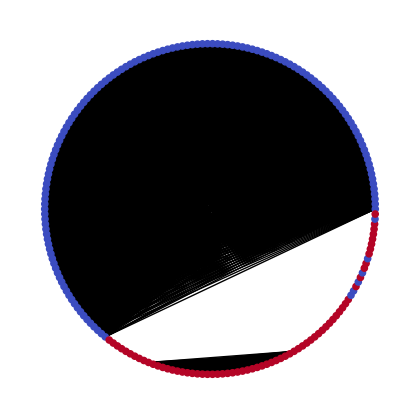

In [6]:
# plot G with the split as colors
import matplotlib.pyplot as plt
import networkx as nx

colors = 1 * data.train_mask + 3 * data.test_mask

plt.figure(figsize=(4, 4))
nx.draw_circular(G, with_labels=False, node_color=colors, cmap=plt.cm.coolwarm, node_size=20)
plt.show()

In [4]:
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, edge_dim=1, num_layers=2, dropout=0.3):
        super(GNN, self).__init__()
        self.convs = nn.ModuleList([GATConv(in_channels, hidden_channels, edge_dim=edge_dim, dropout=dropout)])
        for _ in range(num_layers - 2):
            self.convs.append(GATConv(hidden_channels, hidden_channels, edge_dim=edge_dim, dropout=dropout))
        self.convs.append(GATConv(hidden_channels, out_channels, edge_dim=edge_dim, dropout=dropout))

    def forward(self, x, edge_index, edge_attr=None):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index, edge_attr=edge_attr)
            if i < len(self.convs) - 1:
                x = x.relu()
        return x
    
class TraitsPredictor(nn.Module):
    def __init__(self, in_traits, in_phylo, in_space, hidden_channels, out_channels, num_layers, dropout=0.3):
        super(TraitsPredictor, self).__init__()
        self.space_gnn = GNN(in_space+2, hidden_channels, hidden_channels, num_layers=num_layers)
        self.bipartite_conv = GATConv((hidden_channels, -1), hidden_channels, edge_dim=1, add_self_loops=False)
        self.species_gnn = GNN(in_traits + in_phylo + hidden_channels, hidden_channels, hidden_channels, num_layers=num_layers)
        self.fc = nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        space_input = torch.cat([data.x_spatial, data.global_data], dim=1)
        space_embeddings = self.space_gnn(space_input, data.edge_index_spatial, data.edge_attr_spatial).relu()

        space_to_species = self.bipartite_conv((space_embeddings, None), data.bip_edge_index, data.bip_edge_attr,
                                               size=(space_embeddings.size(0), data.x_species.size(0)))
        # space_to_species = self.bipartite_conv((space_embeddings, torch.zeros_like(data.x_species)), data.bip_edge_index, data.bip_edge_attr)
        species_input = torch.cat([space_to_species, data.x_species, data.x_species_phylo], dim=1)
        species_embeddings = self.species_gnn(species_input, data.edge_index_species, data.edge_attr_species).relu()
        return self.fc(species_embeddings)
    
model = TraitsPredictor(in_traits=data.x_species.size(1), in_phylo=data.x_species_phylo.size(1), 
                        in_space=data.global_data.size(1), hidden_channels=16, out_channels=4, num_layers=2)

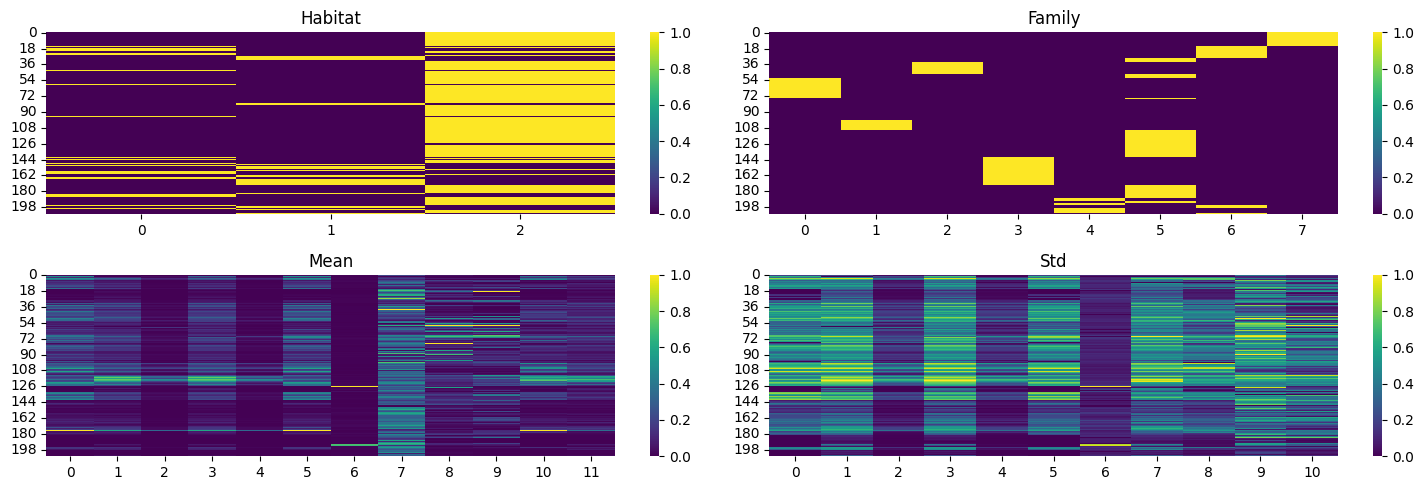

In [6]:
import seaborn as sns

fig, ax = plt.subplots(2, 2, figsize=(15, 5))
ax = ax.flatten()
sns.heatmap((data.x_species[:, torch.arange(len(dataset.traits_all.columns))[[c.startswith('Habitat') for c in dataset.traits_all.columns]]]).numpy(), cmap='viridis', ax=ax[0])
ax[0].set_title('Habitat')

sns.heatmap((data.x_species[:, torch.arange(len(dataset.traits_all.columns))[[c.startswith('Family') for c in dataset.traits_all.columns]]]).numpy(), cmap='viridis', ax=ax[1])
ax[1].set_title('Family')

sns.heatmap((data.x_species[:, torch.arange(len(dataset.traits_all.columns))[[c.endswith('mean') for c in dataset.traits_all.columns]]]).numpy(), cmap='viridis', ax=ax[2])
ax[2].set_title('Mean')

sns.heatmap((data.x_species[:, torch.arange(len(dataset.traits_all.columns))[[c.endswith('Std') for c in dataset.traits_all.columns]]]).numpy(), cmap='viridis', ax=ax[3])
ax[3].set_title('Std')
plt.tight_layout()

In [10]:
data.x_species_traits_nanmask = data.x_species_traits_nanmask[:, dataset.y_index]

In [13]:
torch.save(data, 'data.pt')

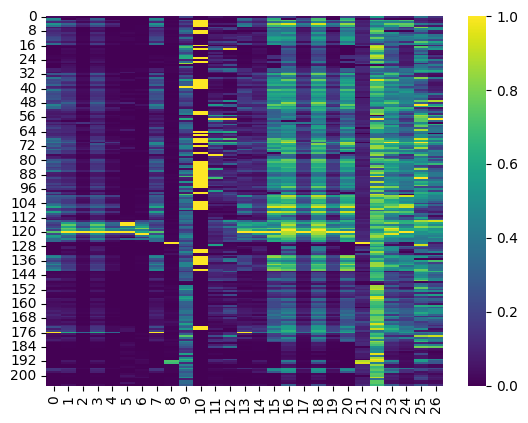

In [12]:
g = sns.heatmap((data.x_species[:, dataset.y_index]*~data.x_species_traits_nanmask).numpy(), cmap='viridis')

In [ ]:
from tqdm.auto import trange
from torch_geometric.utils import subgraph

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
train_mask = train_mask.to(device)
test_mask = test_mask.to(device)
data_y = data.x_species[:, dataset.y_index]*~data.x_species_traits_nanmask

train_data = data.clone()
test_data = data.clone()
for attr in ['x_species', 'x_species_phylo', 'x_species_traits_nanmask']:
    train_data[attr] = train_data[attr][train_mask]
    test_data[attr] = test_data[attr][test_mask]
train_data.edge_index_species, train_data.edge_attr_species = subgraph(train_mask, train_data.edge_index_species, data.edge_attr_species, relabel_nodes=True)
test_data.edge_index_species, test_data.edge_attr_species = subgraph(test_mask, test_data.edge_index_species, data.edge_attr_species, relabel_nodes=True)

In [16]:
model = model.to(device)

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()
Loss = []
test_losses = []
for epoch in trange(200):
    model.train()
    optimizer.zero_grad()
    out = model(train_data)
    out = out*[~data.x_species_traits_nanmask]
    loss = loss_fn(out, data_y)
    loss.backward()
    optimizer.step()
    Loss.append(loss.item())
    
    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    if epoch % 5 == 0:
        model.eval()
        with torch.no_grad():
            out = model(test_data)
            test_loss = loss_fn(out, data_y)
            test_losses.append(test_loss.item())


  0%|          | 0/200 [00:00<?, ?it/s]../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [8,0,0], thread: [0,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [8,0,0], thread: [1,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [8,0,0], thread: [2,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [8,0,0], thread: [3,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [8,0,0], thread: [4,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKern

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# Performance evaluation

In [2]:
import sys
sys.path.append('..')
import pytorch_lightning as pl
from models import TraitsPredictor
from loader import FernDataset, NormalizeFeatures, data_split
from pathlib import Path
import torch

/home/smonaco/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 42

pl.seed_everything(seed)
torch.cuda.manual_seed(seed)

norm_transform = NormalizeFeatures()
dataset = FernDataset(Path('Ferns'), transform=norm_transform)
data = dataset[0]
train_data, test_data = data_split(data)

model = TraitsPredictor(in_traits=data.x_species.size(1), in_phylo=data.x_species_phylo.size(1), 
                        in_space=data.global_data.size(1), hidden_channels=16, out_channels=dataset.y_index.size, 
                        num_layers=2)

model_weight = torch.load('../graph_model.pth', weights_only=False)
model.load_state_dict(model_weight)
model = model.to(device)
model.eval()

data = data.to(device)
test_data = test_data.to(device)

Seed set to 42


In [19]:
import torch.nn.functional as F

mse = torch.nn.MSELoss(reduction='none')
with torch.no_grad():
    # out_all = model(data)
    # out_all = out_all*~data.x_species_traits_nanmask
    # out = out_all[test_mask]
    out = model(test_data)
    out = out*~test_data.x_species_traits_nanmask
    test_rmse = mse(out, test_data.y).pow(.5).cpu().numpy()

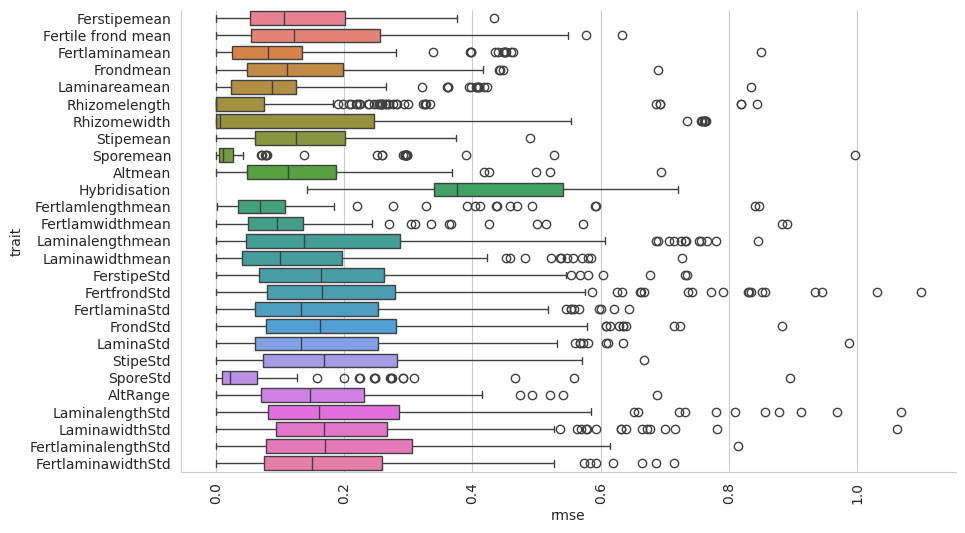

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(10, 6))
test_results = pd.DataFrame(test_rmse, columns=dataset.traits_all.columns[dataset.y_index])
test_results = test_results.melt(var_name='trait', value_name='rmse')
# test.result
sns.boxplot(data=test_results, y='trait', x='rmse', hue='trait')
plt.xticks(rotation=90)
sns.despine()
plt.show()


In [ ]:
from torch_geometric.data import HeteroData
from torch_geometric.explain import Explainer, CaptumExplainer

hetero_data = HeteroData(...)  # A heterogeneous graph data object.

explainer = Explainer(
    model,  # It is assumed that model outputs a single tensor.
    algorithm=CaptumExplainer('IntegratedGradients'),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config = dict(
        mode='multiclass_classification',
        task_level=task_level,
        return_type='probs',  # Model returns probabilities.
    ),
)

# Generate batch-wise heterogeneous explanations for
# the nodes at index `1` and `3`:
hetero_explanation = explainer(
    hetero_data.x_dict,
    hetero_data.edge_index_dict,
    index=torch.tensor([1, 3]),
)
print(hetero_explanation.edge_mask_dict)
print(hetero_explanation.node_mask_dict)